<a href="https://colab.research.google.com/github/jbrent00/Senior-Design-Project/blob/ResNet-18-v1/Senior_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install kaggle


In [9]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"justinbrent","key":"ac26ef4986c10e7725d80b3f23a1a71b"}'}

In [10]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [11]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray

import os

dataset_root = "chest_xray"
print("Dataset contents:", os.listdir(dataset_root))


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORM

In [12]:
!mv /content/chest_xray/chest_xray/* /content/chest_xray/
!rm -r /content/chest_xray/chest_xray
print("Contents of /content/chest_xray:", os.listdir("/content/chest_xray"))



mv: cannot move '/content/chest_xray/chest_xray/chest_xray' to '/content/chest_xray/chest_xray': Directory not empty
Contents of /content/chest_xray: ['test', 'train', '__MACOSX', 'val']


In [13]:
dataset_root = "/content/chest_xray/"

# Paths to Train, Validation, Test Images
train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "val")
test_dir = os.path.join(dataset_root, "test")

# Verify paths
print("Train:", os.listdir(train_dir))
print("Validation:", os.listdir(val_dir))
print("Test:", os.listdir(test_dir))

Train: ['PNEUMONIA', 'NORMAL']
Validation: ['PNEUMONIA', 'NORMAL']
Test: ['PNEUMONIA', 'NORMAL']


In [14]:
# Image Preprocessing (Resizing to 224x224, normalize pixel values, data augmentation)
import torchvision.transforms as transforms

# Define transformations for training and validation/testing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [15]:
# Create PyTorch Dataset and Dataloaders
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Create dataset objects
train_dataset = ImageFolder(root="/content/chest_xray/train", transform=train_transforms)
val_dataset = ImageFolder(root="/content/chest_xray/val", transform=test_transforms)
test_dataset = ImageFolder(root="/content/chest_xray/test", transform=test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 5216
Validation samples: 16
Test samples: 624


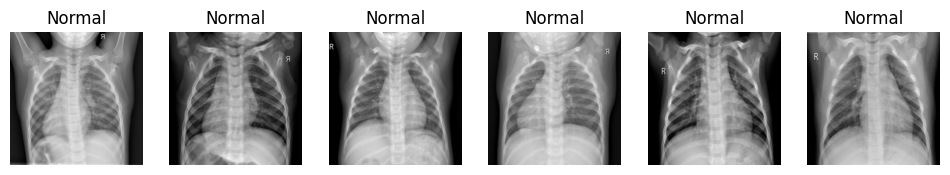

In [16]:
# Display some sample images to confirm dataset is correctly loaded
import matplotlib.pyplot as plt
import numpy as np

# Function to show images
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title("Normal" if label == 0 else "Pneumonia")
        axes[i].axis("off")
    plt.show()

# Display images from the training set
show_images(train_dataset)


In [17]:
print("Class-to-Index Mapping:", train_dataset.class_to_idx)


Class-to-Index Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


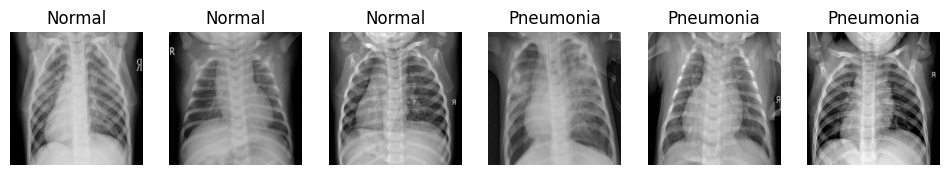

In [18]:
import random

def show_balanced_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    # Collect equal samples of both classes
    normal_images = [img for img, label in dataset if label == 0]
    pneumonia_images = [img for img, label in dataset if label == 1]

    # Ensure we have at least num_images/2 images per class
    num_per_class = num_images // 2
    normal_samples = random.sample(normal_images, min(num_per_class, len(normal_images)))
    pneumonia_samples = random.sample(pneumonia_images, min(num_per_class, len(pneumonia_images)))

    # Combine and shuffle
    samples = normal_samples + pneumonia_samples
    random.shuffle(samples)

    # Display images
    for i, img in enumerate(samples):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title("Normal" if i < num_per_class else "Pneumonia")
        axes[i].axis("off")

    plt.show()

# Display balanced images
show_balanced_images(train_dataset)


In [19]:
# ResNet-18

import torch
import torch.nn as nn
import torchvision.models as models

# Load the ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final fully connected layer for binary classification
num_features = model.fc.in_features  # Get the input size of the FC layer
model.fc = nn.Linear(num_features, 2)  # Change output to 2 classes (NORMAL, PNEUMONIA)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)  # Verify model architecture


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Define Loss Function and Optimizer (using Cross Entropy Loss and Adam Optimizer)

import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [21]:
# Function to Train the Model
# Iterate through the training set in batches, compute the predictions,
# compute the loss, update the models weights, and validate using validation set.

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_avg_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_avg_loss:.4f}, Val Acc: {val_acc:.2f}%")

    print("Training complete!")



In [22]:
# Run the training function
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5] - Loss: 0.1070, Acc: 95.95% | Val Loss: 0.1598, Val Acc: 93.75%
Epoch [2/5] - Loss: 0.0367, Acc: 98.72% | Val Loss: 0.1136, Val Acc: 87.50%
Epoch [3/5] - Loss: 0.0232, Acc: 99.10% | Val Loss: 0.3225, Val Acc: 87.50%
Epoch [4/5] - Loss: 0.0201, Acc: 99.19% | Val Loss: 0.0209, Val Acc: 100.00%
Epoch [5/5] - Loss: 0.0117, Acc: 99.60% | Val Loss: 0.0241, Val Acc: 100.00%
Training complete!


In [23]:
# Function to evaluate the model. Make predictions, calculate accuracy

def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    correct, total = 0, 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class predictions

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_labels, all_preds  # Return results for further analysis


In [24]:
labels, preds = evaluate_model(model, test_loader)

from sklearn.metrics import classification_report

# Print detailed classification metrics
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))


Test Accuracy: 80.61%
              precision    recall  f1-score   support

      NORMAL       0.99      0.49      0.65       234
   PNEUMONIA       0.76      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.74      0.76       624
weighted avg       0.85      0.81      0.79       624



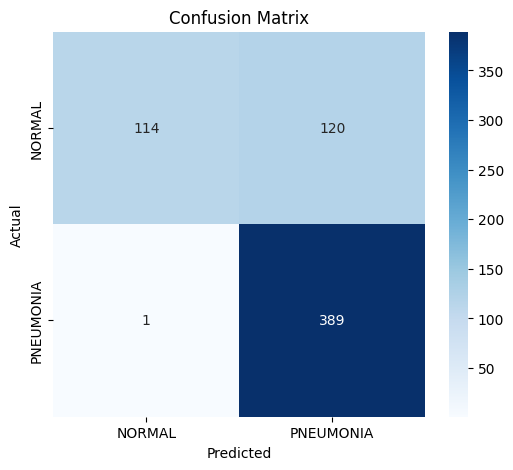

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [27]:
# Save the state dictionary of the model for later use

model_path = "/content/chest_xray_models/resnet18.pth"

# Create the parent directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to /content/chest_xray_models/resnet18.pth
